# **Central Bank of Armenia Policy Report Analysis**
cba-polrep-anal

Github: https://github.com/kwang26mit/cba-polrep-anal

Summarization, analysis, and search functions using NLP for monetary policy reports for the Central Bank of Armenia.

Supported tasks are as follows: 1) Text Summarization, 2) Topical Modeling, 3) Sentiment Analysis, 4) Question-Answering on Specific Metrics, 5) Information Retrieval on General Metrics. The available settings are as follows.

**Document-Based Information Retrieval**
The user selects a document for a specific year. The document will be accompanied by a 1) summary as well as 2) a list of the most discussed topics in the report. In addition, a 3) sentiment analysis showcasing the outlook on each economic factor (positive, negative, neutral) will be provided for that year. There will also be an input where 4) one can query with a specific question: An answer will be given as well as the relevant excerpt from the document supporting that answer.

**Metric-Based Information Retrieval**
The user can choose whether to 2) look for trends of topics over time, 3) perform sentiment analysis over time, or 5) query for specific metrics. For 2) and 3), graphs will be displayed over time, separated by their specific categories. For 5), the user can input a query and the top relevant excerpts across all documents will be displayed.


Please ensure that the following session options are set before running the code in this notebook.

* Internet -> On

# Data Preparation

This section prepares the data for use, including parsing the quarterly reports, installing models, and fine-tuning a model for better results.

## **Data Parsing**
This section will parse the monetary policy report data into paragraphs to be used for analysis. Please run all the code blocks so the data can be set up for interactive use.

Packages: textract, antiword, subprocess (for converting doc and docx into str), re (regular expressions)

In [1]:
# install required packages (for parsing doc & docx)
# ensure that internet is on to install textract package
!pip install textract --upgrade
!apt-get install antiword

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 71.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 52.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.5/128.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 10.5 MB/s eta 0:00:00
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3960 sha256=c016df88b67baeb2

In [2]:
# document preprocessing methods
import re

def strip_lines(text):
    ''' strips newline characters such that each singular newline is stripped and
    each group of consecutive newline characters only has one newline character'''
    n = len(text) 
    deleted = []
    i = 0
    while i < n:
        if text[i] == '\n':
            deleted.append(i)
            if i != n - 1 and text[i + 1] == '\n':
                first = True
                while i < n - 1 and text[i + 1] == '\n':
                    if first:
                        first = False
                    else:
                        deleted.append(i)
                    i += 1
        i += 1

    deleted.append(n)
    result = ''
    i = 0
    for j in deleted:
        result += text[i:j]
        i = j + 1
    return result

def strip_space(text):
    ''' strips extraneous spaces from text'''
    words = text.split(' ')
    for index in range(len(words) - 1, -1, -1):
        if words[index] == '':
            del words[index]
    result = ' '.join(words)
    return result

def match_sections(text, year, quarter):
    ''' returns list of [section name, section text] in order,
    anything before the EXECUTIVE SUMMARY is labeled as preamble'''
    
    def match_capital(sections):
        names = []
        indices = []
        
        # get section names
        for section in sections:
            section_name = re.findall(r"[A-Z0-9][A-Z0-9, ]*[A-Z0-9]", section)[0]
            index = text.index(section)
            indices.append(index)
            section_name.replace('\n', '')
            names.append(section_name)
        
        return find_sections(text, sections, names, indices)
    
    def match_toc(text):
        toc_index = text.index("Table of Contents")
        sec_one_index = None
        if "1. Executive Summary" in text:
            sec_one_index = text[1000:].index("1. Executive Summary")
        toc = text[toc_index:sec_one_index]
        
        for i in range(len(toc) - 1, -1, -1):
            if toc[i] == "|":
                toc = toc[:i]
                break
        
        toc = toc.replace("|", "")
        toc = toc.replace(".", "")
        toc = toc.replace("\n", " ")
        toc = strip_space(toc)
        
        sections = []
        names = []
        for i in range(1, 5):
            start_ind = toc.index(f" {i} ")
            end_ind = len(toc)
            s1 = f" {i + 1} "
            s2 = f" {i}1 "
            if s1 in toc:
                end_num = s1
                if s2 in toc:
                    end_num = s2
                end_ind = toc.index(end_num)
                
            section = toc[start_ind + 1] + '.' + toc[start_ind + 2:end_ind]
            sections.append(section)
            names.append(section[3:])
        
        text = text[sec_one_index:]
        indices = [text.index(section) for section in sections]
        return find_sections(text, sections, names, indices)
        
    def find_sections(text, sections, names, indices):
        # get section texts
        result = []
        for i in range(len(indices) - 1):
            name = names[i]
            start_index = indices[i] + len(sections[i])
            end_index = indices[i + 1]
            result.append([name, text[start_index:end_index]])
            
        # append last section
        name = names[-1]
        start_index = indices[-1] + len(sections[-1])
        result.append([name, text[start_index:]])
        return result
    
    # matches "number. CAPITAL TEXT"
    sections = re.findall(r"[0-9]\. [A-Z][^a-z|\n\.]+ *\n", text)
        
    # if section names matches number. CAPITAL TEXT
    if len(sections) > 0:
        return match_capital(sections)
    else:
        try:
            return match_toc(text)
        except:
            prev_q = quarter - 1
            prev_y = year
            if quarter == 1:
                prev_q = 4
                prev_y = year - 1
            sections = ["1. Executive Summary", 
                        "2. Forecast, Forecast Changes and Risks", 
                        f"3. Actual developments in Q{prev_q}, {prev_y}",
                        "4. Conclusion"]
            count = 0
            i = 0
            while i < len(sections):
                if sections[i] not in text:
                    del sections[i]
                else:
                    count += 1
                    i += 1
                    
            if count < 2:
                sections = ["1. Executive summary", 
                        "2. Scenario presented, scenario changes and risks", 
                        f"3. Actual developments in Q{prev_q}, {prev_y}",
                        "4. Summing-up"] # 2013 Q1, Q2
                if sections[2] not in text:
                    sections[2] = "3. Actual developments in Q4, 2022"
            
            if "Table of Contents" in text:
                conclusion = "4. Conclusion"
                summingup = "4. Summing-up"
                flag = conclusion
                if conclusion not in text:
                    flag = summingup
                index = text.index(flag)
                text = text[index + len(flag):]
            
            names = [sections[3:] for section in sections]
            indices = [text.index(section) for section in sections]
            
            return find_sections(text, sections, names, indices)

def divide_text(text):
    ''' splits text into equal parts <20,000 characters if >20,000 characters 
    to conserve GPU memory'''
    n = len(text)
    if n < 20000:
        return n, [text]
    
    print("Dividing text into parts...")
    
    num_parts = int(n / 20000) + 1
    part_length = int(n / num_parts) + 1
    parts = []
    for i in range(0, n, part_length):
        parts.append(text[i: min(n, i + part_length)])
    return part_length, parts

In [3]:
# classes to hold documents
class ID():
    ''' class to represent a report ID'''
    # fields: year: int, quarter: int
    def __init__(self, year: int, quarter: int):
        if quarter > 4 or quarter < 0:
            raise ValueError(f'improper quarter {quarter}')
        self.year = year
        self.quarter = quarter
        
    def __str__(self):
        return f'({self.year} Q{self.quarter})'

class Report():
    ''' class to represent a quarter policy report '''
    # fields: id: ID, text: str, body: List[Section]
    def __init__(self, id: ID, body: str):
        self.id = id
        self.text = body

        # parse results into sections
        self.body = []
        
        sections = match_sections(body, self.id.year, self.id.quarter)
            
        for name, text in sections:
            section = Section(self.id, name, text)
            self.body.append(section)

    def __str__(self):
        print("This report has " + str(len(self.body)) + " sections.")
        for section in self.body:
            print(section)
            print()
        return description

class Section():
    ''' class to represent a section of a quarter policy report '''
    # fields: id: ID, name: str, text: str, body: List[Paragraph]
    def __init__(self, id: ID, name: str, body: str):
        self.id = id
        self.name = name
        self.text = body
        
        self.body = []
        clean_text = strip_lines(body)
        paras = clean_text.split('\n')
        for para in paras:
            clean_para = strip_space(para)
            if not clean_para.isspace():
                self.body.append(Paragraph(self.id, clean_para))
    
    def __str__ (self):
        print("This section has", len(self.body), "paragraphs and", len(self.text), "characters.")
        description = "SECTION: " + self.name + "\n"
        description += self.text[:1000] + "..."
        return description

class Paragraph():
    ''' class to represent a paragraph of a section of a quarter policy report '''
    # fields: id: ID, section_name: str, body: str
    def __init__(self, id: ID, body: str):
        self.id = id
        self.body = body

    def __str__(self):
        return self.body

In [4]:
import textract
import subprocess

# load document
def decode(text_bytes, docx):
    ''' attempts to decode text using common encodings'''
    common_encodings = ['utf-8', 'latin-1', 'windows-1252']
    text = ''
    for encoding in common_encodings:
        try:
            if docx:
                text = text_bytes.decode(encoding)
            else:
                text = text_bytes.stdout.decode(encoding)
        except:
            continue
    
    return text
    
def parse_doc(fname, qy):
    ''' parse doc into text '''
    quarter = qy.quarter
    year = qy.year 
    
    text = ''
    if '.docx' in fname:
        try:
            text_bytes = textract.process(fname)
            text = decode(text_bytes, True)
        except Exception as e:
            print(f"Error {e} occurred while trying to load Q{quarter}, {year} file")

    elif '.doc' in fname:
        try:
            result = subprocess.run(['antiword', fname], stdout=subprocess.PIPE)
            text = decode(result, False)
        except Exception as e:
            print(f"Error {e} occurred while trying to load Q{quarter}, {year} file")

    else:
        print(f'{fname} is an unparseable file')

    if text != '':
        print(f"Text loaded for Q{quarter}, {year}.")
    else:
        print(f"Error occurred while trying to parse Q{quarter}, {year} file")

    id = ID(year, quarter)
    document = Report(id, text)
    
    return document

In [5]:
# parse multiple documents
import os

path = '/kaggle/input/polrep-v3/data'

def generate_qy(start_y, start_q, end_y, end_q):
    ''' generates year, quarter IDs from start_y, start_q to end_y, end_q inclusive '''
    qys = []
    y = start_y
    q = start_q
    while not (y == end_y and q == end_q):
        qys.append(ID(y, q))
        if q == 4:
            y += 1
            q = 1
        else:
            q += 1
    qys.append(ID(end_y, end_q))
    return qys

def parse_docs(start_y, start_q, end_y, end_q):
    ''' parse reports from range start_y, start_q to end_y, end_q inclusive'''
    qys = generate_qy(start_y, start_q, end_y, end_q)
    
    docs = {}
    for qy in qys:
        quarter = qy.quarter
        year = qy.year
        paths = [path + f'/{year}/Program Q{quarter}, {year} eng.doc',
                path + f'/{year}/Program Q{quarter}, {year} Eng.doc',
                path + f'/{year}/Program Q{quarter}, {year} eng.docx',
                path + f'/{year}/Program Q{quarter}, {year} Eng.docx',
                path + f'/{year}/Program Q{quarter}, {year}eng.docx',
                path + f'/{year}/Program Q{quarter}, {year}Eng.docx',
                ]
        # obtain file path
        file_path = ''
        for p in paths:
            if os.path.exists(p):
                file_path = p
                break
        if file_path == '':
            raise FileNotFoundError(f"Q{quarter}, {year} file does not exist")
        docs[f'Q{quarter}, {year}'] = parse_doc(file_path, qy)
    return docs

In [6]:
# pick document range to analyze
start_y = 2013
start_q = 1

end_y = 2023
end_q = 4

docs = parse_docs(start_y, start_q, end_y, end_q)
# for k, v in docs.items():
#     print(f"{k}: {len(v.body)}")
#     print(f'text length: {len(v.text)}')
#     for sec in v.body:
#         print(f'sec length: {len(sec.text)}')
# print()

Text loaded for Q1, 2013.
Text loaded for Q2, 2013.
Text loaded for Q3, 2013.
Text loaded for Q4, 2013.
Text loaded for Q1, 2014.
Text loaded for Q2, 2014.
Text loaded for Q3, 2014.
Text loaded for Q4, 2014.
Text loaded for Q1, 2015.
Text loaded for Q2, 2015.
Text loaded for Q3, 2015.
Text loaded for Q4, 2015.
Text loaded for Q1, 2016.
Text loaded for Q2, 2016.
Text loaded for Q3, 2016.
Text loaded for Q4, 2016.
Text loaded for Q1, 2017.
Text loaded for Q2, 2017.
Text loaded for Q3, 2017.
Text loaded for Q4, 2017.
Text loaded for Q1, 2018.
Text loaded for Q2, 2018.
Text loaded for Q3, 2018.
Text loaded for Q4, 2018.
Text loaded for Q1, 2019.
Text loaded for Q2, 2019.
Text loaded for Q3, 2019.
Text loaded for Q4, 2019.
Text loaded for Q1, 2020.
Text loaded for Q2, 2020.
Text loaded for Q3, 2020.
Text loaded for Q4, 2020.
Text loaded for Q1, 2021.
Text loaded for Q2, 2021.
Text loaded for Q3, 2021.
Text loaded for Q4, 2021.
Text loaded for Q1, 2022.
Text loaded for Q2, 2022.
Text loaded 

## **Models**
This section will load the models necessary for information retrieval. 

Models: LLAMA 3 (~2.5 min to load, ~1 min to load with checkpoints), Sentence Transformers MiniLM, Cross Encoder MiniLM L6, FinBert

Packages: time (for tracking operation time), torch, transformers (for LLMs), huggingface_hub (for accessing LLAMA 3), IPython.display (for displaying model responses), bitsandbytes (for quantizing model), accelerate (for speeding up LLM), sentence-transformers (for sentence similarity), gc (garbage collect for clearing GPU memory), numpy (for organizing sentiments), yake (keyword extraction), wordcloud (frequency visualization), matplot (data visualization)

In [55]:
# install relevant packages
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install accelerate
!pip install -U sentence-transformers
!pip install yake 
!pip install wordcloud

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple/
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [56]:
# import relevant packages
import time
import torch
import transformers
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, BertTokenizer, BertForSequenceClassification, pipeline
from IPython.display import display, Markdown
from huggingface_hub import login
from sentence_transformers import SentenceTransformer, CrossEncoder
import numpy as np
import matplotlib.pyplot as plt
import yake
from wordcloud import WordCloud

In [9]:
# log into huggingface
# login()

In [10]:
# models
models = {"LLAMA3_PIPE": None, "MINILM_PIPE": None, "XENCODE_PIPE": None, "FINBERT_PIPE": None, "YAKE_EXT": None}

# clear models for gpu memory 
def clear_model(model: str):
    ''' clears model from GPU memory '''
    models[model] = None
    items = gc.collect()
    print(f"Cleared {items} items from GPU memory.")
    torch.cuda.empty_cache()

In [11]:
## LLAMA 3
# load model (~2 min)
# only load once to conserve GPU memory
def llama3_hf_load(task):
    ''' returns pipe of llama 3 8b from huggingface 
    task = text-generation'''
    # model = "meta-llama/Meta-Llama-3-8B-Instruct"
    model = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"

    start = time.time()    
    quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)
    pipeline = transformers.pipeline(
        task,
        model=model,
        torch_dtype = torch.float16,
        # model_kwargs={"torch_dtype": torch.bfloat16, "quantization_config": quantization_config},
        device_map="auto",
    )
    end = time.time()
    print(f"Model loaded in {end - start} seconds.")
    
    return pipeline

models["LLAMA3_PIPE"] = llama3_hf_load('text-generation')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model loaded in 101.42261481285095 seconds.


In [12]:
## LLAMA 3
# query model (~3 sec)
# copied from Prompting-Llama 3-like-a-Pro kaggle notebook
def llama3_hf(system_info, prompt, temperature=0.7, max_length=1024, verbose=True):
    ''' prompts llama3 from huggingface'''
    start = time.time()
    
    # load model
    if models["LLAMA3_PIPE"] == None:
        models["LLAMA3_PIPE"] = llama3_hf_load('text-generation')

    pipeline = models["LLAMA3_PIPE"]
    
    # LLAMA 3 prompt format
    prompt = "Question: " + prompt + " Answer:"
    messages = [
        {"role": "system", "content": system_info},
        {"role": "user", "content": prompt},
        ]
    
    # applys template for better model prompting
    model_prompt = pipeline.tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
        )
    # terminator tokens to parse text correctly
    terminators = [
        pipeline.tokenizer.eos_token_id,
        pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    
    # query
    sequences = pipeline(
        model_prompt,
        do_sample=True,
        top_p=0.9,
        temperature=temperature,
        #num_return_sequences=1,
        eos_token_id=terminators,
        max_new_tokens=max_length,
        return_full_text=False,
        pad_token_id=pipeline.model.config.eos_token_id
    )
    #answer = f"{sequences[0]['generated_text'][len(prompt):]}\n"
    response = sequences[0]['generated_text']
    end = time.time()
    
    if verbose:
        print(f"Query prompted in {end - start} seconds.")

    return prompt + " " + response

In [13]:
## LLAMA 3
# chat template for kaggle
# copied from Prompting-Llama 3-like-a-Pro kaggle notebook
def colorize_text(text):
    for word, color in zip(["Reasoning", "Question", "Answer"], ["blue", "red", "green"]):
        text = text.replace(f"{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

# obtain stripped answer from llama 3 response
def get_answer(response):
    ''' obtains stripped answer from llama 3 response and clears GPU memory '''
    result = colorize_text(response)
    index = result.index("**<font color='green'>Answer:</font>**")
    result = result[index + len("**<font color='green'>Answer:</font>**"):]
    torch.cuda.empty_cache()
    return result

In [14]:
## ST MINILM
# load model
def minilm_hf_load():
    ''' returns pipe of sentence-transformers miniLM l6 from huggingface '''
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    return model

models["MINILM_PIPE"] = minilm_hf_load()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
## ST MINILM
# query model
def minilm_hf(word: str, texts, verbose=True):
    ''' prompts sentence-transformers miniLM l6 from huggingface '''
    
    start = time.time()
    
    # load model
    if models["MINILM_PIPE"] == None:
        models["MINILM_PIPE"] = minilm_hf_load()

    model = models["MINILM_PIPE"]

    sentences = [word] + texts
    embeddings = model.encode(sentences)
    similarities = model.similarity(embeddings, embeddings)
    torch.cuda.empty_cache()
    
    end = time.time()
    
    if verbose:
        print(f"Text similarity retrieved in {end - start} seconds.")
    
    return similarities[[0], 1:]

In [16]:
# X ENCODER MINILM
# load model
def xencode_hf_load():
    ''' returns pipe of cross-encoder miniLM l6 from huggingface '''
    model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512)
    return model

models["XENCODE_PIPE"] = xencode_hf_load()

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [17]:
# X ENCODER MINILM
# query model
def xencode_hf(query, paragraphs, verbose=True):
    ''' prompts cross-encoder miniLM l6 from huggingface '''
    start = time.time()
    
    # load model
    if models["XENCODE_PIPE"] == None:
        models["XENCODE_PIPE"] = minilm_hf_load()

    model = models["XENCODE_PIPE"]
    
    pairs = [(query, paragraph) for paragraph in paragraphs]
    scores = model.predict(pairs)
    
    end = time.time()
    
    if verbose:
        print(f"Cross encoding completed in {end - start} seconds.")
    
    return scores

In [18]:
# FINBERT
# load model
def finbert_hf_load():
    model_name = "yiyanghkust/finbert-tone"
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
    tokenizer = BertTokenizer.from_pretrained(model_name)
    nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, truncation=True, max_length=512)
    return model, tokenizer, nlp

models["FINBERT_PIPE"] = finbert_hf_load()

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [19]:
# FINBERT
# query model
def finbert_hf(texts):
    if models["FINBERT_PIPE"] == None:
        models["FINBERT_PIPE"] = finbert_hf_load()
    
    model, tokenizer, nlp = models["FINBERT_PIPE"]
    
    results = nlp(texts)
    torch.cuda.empty_cache()
    return results

In [57]:
# YAKE
# load model
def yake_load(max_ngram_size: int = 1, deduplication_threshold: float = 0.8, num_of_keywords: int = 50):
    language = "en"
    n = max_ngram_size # how long keywords can be
    dedup_lim = deduplication_threshold # how similar different keywords can be
    top = num_of_keywords # top number of keywords used
    kw_extractor = yake.KeywordExtractor(lan=language, n=n, dedupLim=dedup_lim, top=top, features=None)
    return kw_extractor

models['YAKE_EXT'] = yake_load()

In [58]:
# YAKE
# query model
def yake(text):
    if models['YAKE_EXT'] == None:
        models['YAKE_EXT'] = yake_load()
    
    kw_ext = models['YAKE_EXT']
    kws = kw_ext.extract_keywords(text)
    kws_freq = {word: score for word, score in kws}
    return kws_freq

## Fine-tuning Models

This section will fine-tune the sentence-transformers model for financial data.

Packages: time (for tracking operation time), pandas (dataframes), torch, datasets (datasets), sentence-transformers, random (for labeling)

In [22]:
# install required packages
!pip install wandb
os.environ["WANDB_INIT_TIMEOUT"] = "120"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [23]:
# import required packages
import pandas as pd
import torch
import random
import os
from datasets import Dataset, load_dataset, DatasetDict
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainingArguments, SentenceTransformerTrainer
from sentence_transformers.losses import CoSENTLoss
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers.training_args import BatchSamplers

In [24]:
# load presaved data
data_path = '/kaggle/input/polrep-v3/st-fin-ft'
train_dataset, eval_dataset, test_dataset = None, None, None
if os.path.exists(data_path):
    print("Loading presaved data...")
    train_dataset = load_dataset('json', data_files = data_path + '/train.json')['train']
    eval_dataset = load_dataset('json', data_files = data_path + '/eval.json')['train']
    test_dataset = load_dataset('json', data_files = data_path + '/test.json')['train']
    
print(train_dataset)
print(eval_dataset)
print(test_dataset)
    

Loading presaved data...


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text1', 'text2', 'label'],
    num_rows: 3254
})
Dataset({
    features: ['text1', 'text2', 'label'],
    num_rows: 1085
})
Dataset({
    features: ['text1', 'text2', 'label'],
    num_rows: 1085
})


In [25]:
# generate dataset
# load financial sentences
dataset_path = '/kaggle/input/financial-sentiment-analysis/data.csv'
orig_df = pd.read_csv(dataset_path).drop(columns=['Sentiment'])
sentence_df = orig_df[~orig_df['Sentence'].str.startswith('$')] # clean dataset

print(f"Dataset contains {sentence_df.shape[0]} sentences.")
print(f"Filtered {orig_df.shape[0] - sentence_df.shape[0]} sentences.")

system_info_similar = '''You are an AI assistant designed to paraphrase sentences.
    Please paraphrase the provided financial sentence. '''

system_info_different = '''You are an AI assistant designed to generate unrelated sentences.
    Given the provided sentence, please generate a completely unrelated financial sentence. '''

def generate_dataset(sentence_df):
    ''' generates dataset based on list of text1 given in sentence_df 
    sentence_df: DataFrame '''
    
    start = time.time()
    i = 0
    n = sentence_df.shape[0]
    dataset = []
    
    print(f"Dataset generating on {n} sentences...")
    
    for value in sentence_df['Sentence']:
        text1 = value
        label = random.choice([0.0, 1.0])
        
        # generate text 2
        system_info = system_info_different
        if label == 1.0:
            system_info = system_info_similar
        
        # prompt llama 3
        response = llama3_hf(system_info, prompt=text1, temperature=0.1, max_length=50, verbose = False)
        text2 = get_answer(response)
        dataset.append([text1, text2, label])
        
        i += 1
        if i % 20 == 0:
            print(f'Finished {i} out of {n} queries...')
            
    end = time.time()
    print(f"Dataset generated in {end - start} seconds.")
    return dataset

dataset = None
if train_dataset == None:
    n = 5424
    dataset = generate_dataset(sentence_df.head(n))

Dataset contains 5424 sentences.
Filtered 418 sentences.


In [26]:
# prepare training data
def convert_dataset(dataset, train_percent: int = 0.7, eval_percent: int = 0.15):
    ''' creates training, evaluation, and test Dataset with features text1, text2, and label
    where percent percent is the amount of data used in train_dataset 
    data: List[[text1, text2, label]]'''

    train_dataset = {'text1': [], 'text2': [], 'label': []}
    eval_dataset = {'text1': [], 'text2': [], 'label': []}
    test_dataset = {'text1': [], 'text2': [], 'label': []}
    
    index1 = train_percent * len(dataset) - 1
    index2 = (train_percent + eval_percent) * len(dataset) - 1
    
    for i, pair in enumerate(dataset):
        text1, text2, label = pair
        d = train_dataset
        if i > index2:
            d = test_dataset
        elif index1 < i and i <= index2:
            d = eval_dataset

        d['text1'].append(text1)
        d['text2'].append(text2)
        d['label'].append(label)
    
    train_dataset = Dataset.from_pandas(pd.DataFrame(train_dataset))
    eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_dataset))
    test_dataset = Dataset.from_pandas(pd.DataFrame(test_dataset))
    
    return train_dataset, eval_dataset, test_dataset

if train_dataset == None:
    train_dataset, eval_dataset, test_dataset = convert_dataset(dataset, train_percent = 0.6, eval_percent = 0.2)
    train_dataset.to_json('/kaggle/working/datasets/train.json')
    eval_dataset.to_json('/kaggle/working/datasets/eval.json')
    test_dataset.to_json('/kaggle/working/datasets/test.json')

print(train_dataset)
print(eval_dataset)
print(test_dataset)

Dataset({
    features: ['text1', 'text2', 'label'],
    num_rows: 3254
})
Dataset({
    features: ['text1', 'text2', 'label'],
    num_rows: 1085
})
Dataset({
    features: ['text1', 'text2', 'label'],
    num_rows: 1085
})


In [27]:
# loss
# load model to finetune
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# use CoSENTLoss, AnglELoss, or CosineSimilarityLoss for [text1, text2, label] format
# requires pairs of text and a float similarity score as a label
loss = CoSENTLoss(model)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [28]:
# obtain evaluators
def obtain_evaluator(dataset: Dataset, name: str):
    evaluator = EmbeddingSimilarityEvaluator(
        sentences1=eval_dataset["text1"],
        sentences2=eval_dataset["text2"],
        scores=eval_dataset["label"],
        main_similarity=SimilarityFunction.COSINE,
        name=name,
    )
    return evaluator

orig_evaluator = obtain_evaluator(eval_dataset, 'sts-dev')
ft_evaluator = obtain_evaluator(test_dataset, 'sts-test')

# evaluate old model
print(orig_evaluator(model))

{'sts-dev_pearson_cosine': 0.9446940138008114, 'sts-dev_spearman_cosine': 0.8584421276728195, 'sts-dev_pearson_manhattan': 0.9214596668393245, 'sts-dev_spearman_manhattan': 0.8588310509786702, 'sts-dev_pearson_euclidean': 0.9215884400846234, 'sts-dev_spearman_euclidean': 0.8584421276728195, 'sts-dev_pearson_dot': 0.9446940156560397, 'sts-dev_spearman_dot': 0.8584421276728195, 'sts-dev_pearson_max': 0.9446940156560397, 'sts-dev_spearman_max': 0.8588310509786702}


In [29]:
# training arguments
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="models/st-fin-ft",
    # Optional training parameters:
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses that use "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name="st-fin-ft",  # Will be used in W&B if `wandb` is installed
)

In [30]:
# train model (~100 seconds)
start = time.time()
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=orig_evaluator,
)
trainer.train()
end = time.time()
print(f'Training finished in {end - start} seconds.')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Sts-dev Pearson Cosine,Sts-dev Spearman Cosine,Sts-dev Pearson Manhattan,Sts-dev Spearman Manhattan,Sts-dev Pearson Euclidean,Sts-dev Spearman Euclidean,Sts-dev Pearson Dot,Sts-dev Spearman Dot,Sts-dev Pearson Max,Sts-dev Spearman Max
100,0.178800,0.001002,0.985639,0.864895,0.976974,0.864895,0.976982,0.864895,0.985639,0.864895,0.985639,0.864895
200,0.000100,0.031195,0.986803,0.864836,0.978119,0.864836,0.978065,0.864836,0.986803,0.864836,0.986803,0.864836
300,0.020800,0.000020,0.989941,0.864912,0.985585,0.864912,0.985595,0.864912,0.989941,0.864912,0.989941,0.864912
400,0.000000,0.005528,0.988829,0.864859,0.981604,0.864859,0.981547,0.864859,0.988829,0.864859,0.988829,0.864859
500,0.000000,0.002272,0.989860,0.864895,0.983255,0.864895,0.983206,0.864895,0.989860,0.864895,0.989860,0.864895


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Training finished in 214.08560252189636 seconds.


In [31]:
# evaluate new model
print(ft_evaluator(model))

{'sts-test_pearson_cosine': 0.9898706727628048, 'sts-test_spearman_cosine': 0.8648947188835235, 'sts-test_pearson_manhattan': 0.9832729289257899, 'sts-test_spearman_manhattan': 0.8648947188835235, 'sts-test_pearson_euclidean': 0.9832239806176275, 'sts-test_spearman_euclidean': 0.8648947188835235, 'sts-test_pearson_dot': 0.989870672305574, 'sts-test_spearman_dot': 0.8648947188835235, 'sts-test_pearson_max': 0.9898706727628048, 'sts-test_spearman_max': 0.8648947188835235}


In [32]:
# save model
model.save_pretrained("models/st-fin-ft/final")

# load model
model_path = '/kaggle/working/models/st-fin-ft/final'
models['MINILM_PIPE'] = SentenceTransformer(model_path)

# CBA Policy Report Interactive Analysis


# Document Based Information Retrieval
Choose a document to analyze. The currently supported settings are as follows.
1. Summarization: Summarizes the text briefly.
2. Question-Answering: Answers questions based on the document.

In [61]:
# pick document to analyze
year = 2022
quarter = 2

docs = parse_docs(year, quarter, year, quarter)
document = docs[f'Q{quarter}, {year}']

Text loaded for Q2, 2022.


## Summarization

Provides a few sentence summary of the relevant document.

In [78]:
# generate summary
def llama3_hf_sum(doc):
    system_info_sum = '''You are an AI assistant designed to summarize documents.
    According to only the provided document and no other sources, please very briefly summarize 
    the provided document.
    '''
    system_info_com = '''You are an AI assistant designed to combine summaries.
    You will be provided summaries of consecutive parts of the same document. Please combine the
    provided summaries to create a comprehensive summary of the entire document. As the 
    summaries you are given may have repeated information, please briefly summarize while 
    refraining from repeating information.
    '''
    
    start = time.time()
    
    prompt = ''
    n = len(doc.text)
    results = ''
    counter = 0
        
    flag = True
    # summarize parts of document
    for section in doc.body:
        print("Processing section", section.name)
        if flag:
            length, parts = divide_text(section.text)
            for i in range(len(parts)):
                print("Processing characters", counter, "to", min(n, length))
                counter += length
                prompt = parts[i]
                response = llama3_hf(system_info_sum, prompt=prompt, temperature=0.1, max_length=500)
                result = get_answer(response)
                results += result + '\n\n'
            flag = False

    # combine summaries
    print("Combining results...")
    prompt = results
    response = llama3_hf(system_info_com, prompt=prompt, temperature=0.1, max_length=750)
    result = get_answer(response)
    
    end = time.time()
    print(f"Summary completed in {end - start} seconds.")
    
    return result

In [79]:
# summarize
print(llama3_hf_sum(document))

Processing section EXECUTIVE SUMMARY
Processing characters 0 to 4926
Query prompted in 12.390738248825073 seconds.
Processing section SCENARIO PRESENTED, SCENARIO CHANGES AND RISKS
Processing section ACTUAL DEVELOPMENTS IN Q3, 2023
Processing section SUMMING
Combining results...
Query prompted in 8.735652446746826 seconds.
Summary completed in 21.172183990478516 seconds.
 Here is a comprehensive summary of the document:

The Armenian economy is expected to experience a slowdown due to the economic downturn in its major trade partner countries. Despite this, the Central Bank of Armenia predicts that the 12-month inflation rate will remain below target, reaching 0.1% by the end of 2023. To maintain consistency and stability in inflation expectations, the bank plans to ease monetary conditions gradually. Meanwhile, Armenia's economic growth is expected to remain strong, driven by growth in the services and construction sectors, with a projected growth rate of 8.3% by the end of 2023.


## Question-Answering on Specific Metrics

Answers questions on a specific document.

In [82]:
# query answering
def llama3_hf_qa(doc, q):
    system_info_qa = '''You are an AI assistant designed to answer questions.
    According to only the provided document and no other sources, please answer the question.
    '''
    system_info_com = '''You are an AI assistant designed to answer questions. You will be 
    given the best generated answer to the question from each piece of the document. According
    to the separate answers given, please pick the best answer or combine multiple answers 
    that best answers the provided question. Your answer should be brief.''' 
    
    start = time.time()
    n = len(doc.text)
    results = ''
    num_ans = 1
    counter = 0
    
    for section in doc.body:
        print("Processing section", section.name, "...")
        length, parts = divide_text(section.text)
        for i in range(len(parts)):
            print("Processing characters", counter, "to", counter + min(n, length))
            counter += length
            prompt = "Question: " + q + "\n\n"
            prompt += "Document: " + parts[i]
            response = llama3_hf(system_info_qa, prompt=prompt, temperature=0.1, max_length=500)
            result = get_answer(response)
            results += "ANSWER " + str(num_ans) + ": " + result + '\n\n'
            num_ans += 1
            
    # combine answers
    print("Combining results...")
    prompt = "Question: " + q + "\n\n" + results
    response = llama3_hf(system_info_com, prompt=prompt, temperature=0.1, max_length=500)
    result = get_answer(response)
    
    end = time.time()
    print(f"Question-answering completed in {end - start} seconds.")
    
    return q, result

In [92]:
# qa
question = "Are there any forward guidance or future policy directions provided?"
q, a = llama3_hf_qa(document, question)

print()
print("Question:", q)
print("Answer:", a)

Processing section Executive Summary ...
Processing characters 0 to 7900
Query prompted in 10.440423250198364 seconds.
Processing section Forecast, Forecast Changes and Risks ...
Dividing text into parts...
Processing characters 7900 to 21981
Query prompted in 8.63745903968811 seconds.
Processing characters 21981 to 36062
Query prompted in 8.440870761871338 seconds.
Processing characters 36062 to 50143
Query prompted in 13.918516397476196 seconds.
Processing section Actual Developments in Q4, 2015 ...
Dividing text into parts...
Processing characters 50143 to 67407
Query prompted in 10.49182415008545 seconds.
Processing characters 67407 to 84671
Query prompted in 10.492761135101318 seconds.
Processing characters 84671 to 101935
Query prompted in 12.593942403793335 seconds.
Processing section Conclusion ...
Processing characters 101935 to 116828
Query prompted in 12.037605285644531 seconds.
Combining results...
Query prompted in 7.569791793823242 seconds.
Question-answering completed in

## Keyword Extraction

Extracts top 25 keywords in document and generates a word cloud for them.

In [59]:
# extract keywords across document
def kw_extract(doc: Report, verbose=True):
    ''' extracts top 25 keywords from doc '''
    start = time.time()
    
    # clean text
    text = doc.text
    text= text.lower()
    omitted = ['cba', 'central', 'bank', 'armenia', 'economy', 'quarter', 'year', 'previous']
    for word in omitted:
        text.replace(word, '')
    
    freqs = yake(text)
    for word in omitted:
        if word in freqs:
            del freqs[word]
        
    end = time.time()
    if verbose:
        print(f'Keywords extracted in {end - start} seconds.')
    return freqs

# generate word cloud
def plot_kw(freqs):
    ''' plots keywords and frequencies with a word cloud '''
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
    
    # display
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Keywords extracted in 2.1214330196380615 seconds.


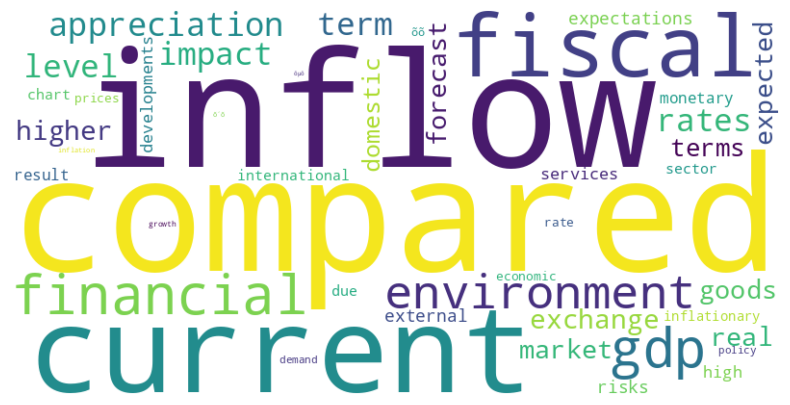

In [62]:
# extract keywords
freqs = kw_extract(document)
plot_kw(freqs)

## Topic Modeling

Find top topics of given document.

In [70]:
# find top topics (< 1 second)
def minilm_hf_tm(topics, doc: Report, k: int, examples: bool, verbose: bool = True):
    ''' finds top k topics in doc and prints top paragraph results of examples is True 
    topics: List[str]'''
    
    if len(topics) == 0:
        raise ValueError("No topics provided.")
    
    start = time.time()
    
    texts = filter_large(doc)
    n = len(texts)
    
    # get topics
    top_results = [] # [[similarity, paragraph]...]
    top_topics = [] # List[int] similarities
    para_sims = {}
    for topic in topics:
        similarities = minilm_hf(topic, texts, verbose)
        para_sim = [float(similarities[[0], [i]]) for i in range(n)]
        
        # find similarity
        avg_similarity = torch.mean(similarities, 1, True)
        top_topics.append(float(avg_similarity[[0], [0]]))
        
        # find top result
        if examples:
            similarity, ind = torch.max(similarities, dim=1)
            top_results.append([float(similarity[0]), texts[int(ind[0])]]) # paragraph
        para_sims[topic] = para_sim
        
    sorted_topics = top_topics.copy()
    sorted_topics.sort()
    
    if len(sorted_topics) > k:
        sorted_topics = sorted_topics[-k:]
    sorted_topics.reverse()
              
    end = time.time()
    print(f"Topics retrieved in {end - start} seconds.")
    
    return top_topics, sorted_topics, top_results, n, para_sims

def filter_large(doc: Report, space_thresh=5, faulty_thresh=250):
    ''' filters for large enough paragraphs '''
    texts = []
    faulty = 0
    # get paragraphs in list
    for section in doc.body:
        for paragraph in section.body:
            spaces = paragraph.body.count(' ')
            if spaces > 5:
                texts.append(paragraph.body)
            if paragraph.body.count(' ') > 250:
                faulty += 1
                
    # number of paragraphs with faulty results (greater than model max sequence length)
    print(f"{faulty} paragraphs with possibly faulty results.")
    
    return texts

def tm_response(topics, top_topics, sorted_topics, top_results):
    description = 'Topics: '
    for topic, similarity in zip(topics, top_topics):
        description += f"{topic}: ({round(similarity, 2)}), "
    description = description[:-2]
    print('\n' + description + '\n')
        
    counter = 1
    for similarity in sorted_topics:
        index = top_topics.index(similarity)
        print(f"#{counter}. {topics[index]}")
        if examples:
              print(f"Top Result: {round(top_results[index][0], 2)} similarity")
              print(f"{top_results[index][1]}\n")
        counter += 1

def plot_tm(n, para_sims):
    ''' graphs similarity to topic across document paragraphs '''
    plt.figure(figsize=(12, 6))
    paras = [i for i in range(n)]
    for topic, similarities in para_sims.items():
        plt.plot(paras, similarities, label=topic)
    
    # label axes
    plt.xlabel("Paragraphs")
    plt.ylabel("Similarity Scores (0 to 1)")
    plt.title("Trending Topics Over Document")
    plt.ylim(0, 0.75)
    plt.legend()
    plt.grid(True)
    plt.show()

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.35657477378845215 seconds.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.2733025550842285 seconds.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.27728748321533203 seconds.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.27977585792541504 seconds.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.27730345726013184 seconds.
Topics retrieved in 1.4823360443115234 seconds.

Topics: demand shocks: (0.32), supply shocks: (0.26), foreign policy: (0.14), russia: (0.06), inflation: (0.38)

#1. inflation
Top Result: 0.66 similarity
In the light of the aforementioned developments in external and domesticeconomies, in the first quarter of 2013 the 12-month inflation behavedrelatively steadily, as was expected, reaching 3.4 percent at the end ofMarch thus staying in the lower bound of the band.

#2. demand shocks
Top Result: 0.57 similarity
|The global demand remains ||sluggish; no considerable ||inflationary trends are ||observable in basic commodities ||markets, either. Moreover, later||in the first quarter certain ||deflationary patterns were ||noticed in some markets. |

#3. supply shocks
Top Result: 0.54 similarity
Recent developments in the domestic economy are characterized by higher-than-expected economic activity and 12-month inflation close to the t

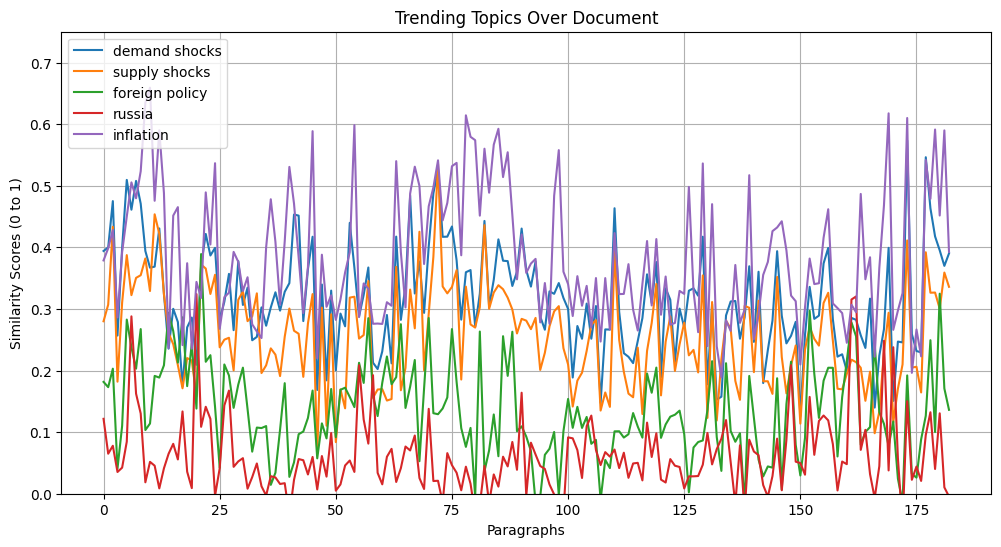

In [46]:
# choose topics here
topics = ['demand shocks', 'supply shocks', 'foreign policy', 'russia', 'inflation']
k = 3 # number of topics chosen
examples = True # True: print topics with top paragraph results, False: only print topics
top_topics, sorted_topics, top_results, n, para_sims = minilm_hf_tm(topics, document, k, examples)
tm_response(topics, top_topics, sorted_topics, top_results)
plot_tm(n, para_sims)

## Sentiment Analysis
Describes the report outlook on different topics.

In [26]:
# filter similarity
def filter_paras(topic: str, texts, thresh: int = 0.2):
    ''' filters for paragraphs with >thresh similarity to topic '''
    similarities = minilm_hf(topic, texts)
    paras = [text for i, text in enumerate(texts) if similarities[[0], [i]] > thresh]
    return paras

# sentiment analysis
def finbert_hf_sa(topics, doc: Report, verbose: bool = True):
    ''' finds sentiment analysis for topics across text '''
    
    if len(topics) == 0:
        raise ValueError("No topics provided.")
        
    start = time.time()
    
    texts = filter_large(doc)
    results = []
    for topic in topics:
        paras = filter_paras(topic, texts)
        print(f"Surveying {len(paras)} paragraphs for {topic}...")
        scores = finbert_hf(paras)
        sentiments = [-1 if scores[i]['label'] == 'Negative'
                     else 1 if scores[i]['label'] == 'Positive'
                     else 0
                     for i in range(len(paras))]
        if len(sentiments) != 0:
            result = float(sum(sentiments)/len(sentiments))
            results.append(result)
        else:
            results.append(0) # if no sentiments
    
    end = time.time()
    if verbose:
        print(f'Sentiment analysis completed in {end - start} seconds.')
    
    return results

# print sentiment analysis
def display_sa(topics, scores, doc: Report):
    ''' prints sentiment for each topic for doc '''
    for topic, score in zip(topics, scores):
        sentiment = 'neutral'
        if -1 <= score <= -2 / 3:
            sentiment = 'negative'
        elif 2 / 3 <= score <= 1:
            sentiment = 'positive'
        print(f'{topic}: {sentiment} ({score:.2f})')

In [66]:
# perform sentiment analysis
topics = ['inflation', 'unemployment', 'oil', 'foreign policy'] # choose topics here
results = finbert_hf_sa(topics, document)
print()
display_sa(topics, results, document)

1 paragraphs with possibly faulty results.
here


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.39550256729125977 seconds.
Surveying 181 paragraphs for inflation...
here


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.4064009189605713 seconds.
Surveying 35 paragraphs for unemployment...
here


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.39034318923950195 seconds.
Surveying 9 paragraphs for oil...
here


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3196566104888916 seconds.
Surveying 39 paragraphs for foreign policy...
Sentiment analysis completed in 31.173088788986206 seconds.

inflation: neutral (0.12)
unemployment: neutral (0.29)
oil: neutral (-0.11)
foreign policy: neutral (-0.05)


# Metric Based Information Retrieval
Choose a document to analyze. The currently supported settings are as follows.
1. Topic Modeling Over Time: Look for trends of topics over time.
2. Information Retrieval: Search all documents for specific information.


The user can choose whether to 2) look for trends of topics over time, 3) perform sentiment analysis over time, or 5) query for specific metrics. For 2) and 3), graphs will be displayed over time, separated by their specific categories. For 5), the user can input a query and the top relevant excerpts across all documents will be displayed.

In [86]:
# pick document range to analyze
start_y = 2022
start_q = 1

end_y = 2022
end_q = 2

docs = parse_docs(start_y, start_q, end_y, end_q)
print()

Text loaded for Q1, 2022.
Text loaded for Q2, 2022.



## Keyword Extraction Over Time

See frequencies of keywords during specified time periods.

In [64]:
# extract all keywords (~40 seconds)
def kw_extract_all(docs, n: int = 25):
    ''' extracts top n keywords across all docs where n <= 25'''
    docs: Dict[Report]
    start = time.time()
    
    all_kws = {}
    for qy, doc in docs.items():
        freqs = kw_extract(doc, verbose=False)
        for word, score in freqs.items():
            all_kws[word] = all_kws.get(word, 0) + score
    
    top = sorted(all_kws.items(), key=lambda item: item[1], reverse=True) # sort by score
    top_n = dict(top[:n])
    
    end = time.time()
    print(f'All keywords extracted in {end - start} seconds.')
    
    return top_n

All keywords extracted in 3.276090383529663 seconds.


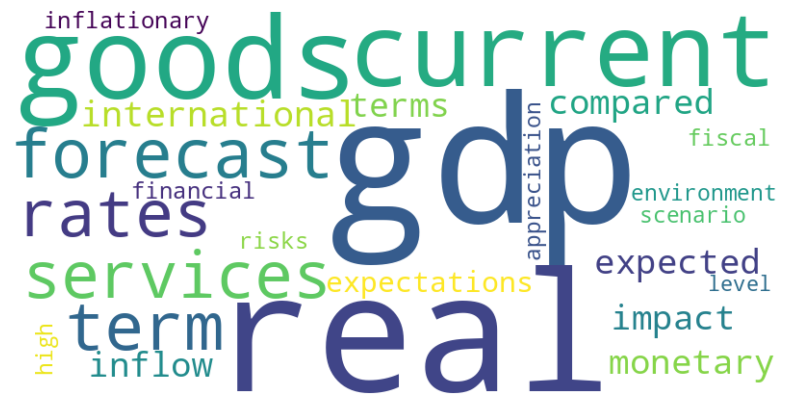

In [87]:
# extract all keywords
freqs = kw_extract_all(docs)
plot_kw(freqs)

## Topic Modeling Over Time

See trends of topics over time.

In [84]:
def minilm_tm_all(topics, docs):
    ''' finds topic similarity for topics across all docs 
    topics: List[str], docs: Dict[Report]'''
    start = time.time()
    
    results_list = [] # [quarter, year, similarities]
    for key, doc in docs.items():
        quarter = key[1]
        year = key[4:]        
        top_topics, sorted_topics, top_results, n, para_sims = minilm_hf_tm(topics, doc, len(topics), False, verbose = False)
        results_list.append([quarter, year, top_topics])
        
    results_dict = {}
    for topic in topics:
        results_dict[topic] = []
    for result in results_list:
        similarities = result[2]
        for i in range(len(topics)):
            results_dict[topics[i]].append(similarities[i])   
            
    end = time.time()
    print(f"All topics retrieved in {end - start} seconds.")
    
    return results_list, results_dict

def tm_responses(topics, by_year, by_metric):
    ''' formats minilm topic modeling results across documents 
    by_year: List[List[quarter, year, similarities]], by_metric: Dict{topic: List[similarity]}'''
    # by year
    for quarter, year, similarities in by_year:
        description = f"{year} Q{quarter}: "
        for topic, similarity in zip(topics, similarities):
            description += f"{topic} ({round(similarity, 4)}), "
        description = description[:-2]
        print(description)

    print()
    # by metric
    for key, values in by_metric.items():
        description = f"{key}: "
        for value in values:
            description += f"{round(value, 4)} "
        print(description)

def plot_tm_all(results_list, results_dict):
    ''' plots topic modeling results using matplot 
    results_list: List[[quarter, year, score]]
    results_dict: Dict{topic: List[similarity]}'''
    
    plt.figure(figsize=(12, 6))
    qys = [f'{year} Q{quarter}' for quarter, year, similarities in results_list]
    for topic, similarities in results_dict.items():
        plt.plot(qys, similarities, label=topic)
    
    # label axes
    plt.xticks(rotation=90)
    plt.xlabel("Time (quarterly)")
    plt.ylabel("Similarity Scores (0 to 1)")
    plt.title("Trending Topics Over Time")
    
    plt.axvspan(qys.index('2019 Q4'), qys.index('2020 Q2'), color='red', alpha=0.3, label='COVID-19') # covid period
    plt.axvline(x=qys.index('2022 Q1'), color='b', linestyle='--', label='Russia-Ukraine War')

    plt.ylim(0, 0.4)
    plt.legend()
    plt.grid(True)
    plt.show()

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Topics retrieved in 0.9052281379699707 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics retrieved in 0.9916133880615234 seconds.
5 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Topics retrieved in 0.6842410564422607 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics retrieved in 0.8574681282043457 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics retrieved in 1.1008226871490479 seconds.
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Topics retrieved in 0.8665401935577393 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Topics retrieved in 0.899183988571167 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Topics retrieved in 0.8289315700531006 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Topics retrieved in 0.9938583374023438 seconds.
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Topics retrieved in 0.9416415691375732 seconds.
19 paragraphs with possibly faulty results.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Topics retrieved in 0.6305587291717529 seconds.
21 paragraphs with possibly faulty results.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Topics retrieved in 0.6912999153137207 seconds.
24 paragraphs with possibly faulty results.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Topics retrieved in 0.6812427043914795 seconds.
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Topics retrieved in 0.9084205627441406 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Topics retrieved in 1.0311987400054932 seconds.
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics retrieved in 0.8554573059082031 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Topics retrieved in 0.9542927742004395 seconds.
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics retrieved in 0.6890790462493896 seconds.
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Topics retrieved in 0.6433660984039307 seconds.
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Topics retrieved in 0.737565279006958 seconds.
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Topics retrieved in 0.6384258270263672 seconds.
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Topics retrieved in 0.6508824825286865 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics retrieved in 0.711322546005249 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics retrieved in 0.7302448749542236 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Topics retrieved in 0.6600086688995361 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Topics retrieved in 0.6760573387145996 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics retrieved in 0.7001097202301025 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics retrieved in 0.6925444602966309 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Topics retrieved in 0.7139081954956055 seconds.
3 paragraphs with possibly faulty results.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Topics retrieved in 0.6084058284759521 seconds.
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Topics retrieved in 0.9917647838592529 seconds.
3 paragraphs with possibly faulty results.


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Topics retrieved in 0.8822133541107178 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Topics retrieved in 1.1004440784454346 seconds.
4 paragraphs with possibly faulty results.


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Topics retrieved in 1.7094428539276123 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Topics retrieved in 0.9244332313537598 seconds.
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Topics retrieved in 1.0201199054718018 seconds.
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Topics retrieved in 1.2279424667358398 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Topics retrieved in 1.7227749824523926 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Topics retrieved in 1.5290327072143555 seconds.
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Topics retrieved in 0.8690841197967529 seconds.
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Topics retrieved in 1.101456880569458 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics retrieved in 0.7482068538665771 seconds.
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Topics retrieved in 0.9251976013183594 seconds.
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Topics retrieved in 0.9046931266784668 seconds.
All topics retrieved in 39.361605405807495 seconds.
2013 Q1: uncertainty (0.2206), risks (0.2062), concerns (0.2722)
2013 Q2: uncertainty (0.2178), risks (0.2054), concerns (0.2742)
2013 Q3: uncertainty (0.2039), risks (0.1966), concerns (0.254)
2013 Q4: uncertainty (0.2334), risks (0.2148), concerns (0.2858)
2014 Q1: uncertainty (0.2424), risks (0.2208), concerns (0.2973)
2014 Q2: uncertainty (0.2331), risks (0.2192), concerns (0.2899)
2014 Q3: uncertainty (0.2271), risks (0.2159), concerns (0.2899)
2014 Q4: uncertainty (0.1882), risks (0.1794), concerns (0.2348)
2015 Q1: uncertainty (0.1833), risks (0.1778), concerns (0.2381)
2015 Q2: uncertainty (0.18), risks (0.175), concerns (0.2332)
2015 Q3: uncertainty (0.1697), risks (0.1553), concerns (0.2118)
2015 Q4: uncertainty (0.2158), risks (0.1981), concerns (0.2599)
2016 Q1: uncertainty (0.2127), risks (0.1961), concerns (0.2604)
2016 Q2: uncertainty (0.1625), risks (0.1655), concerns (0.

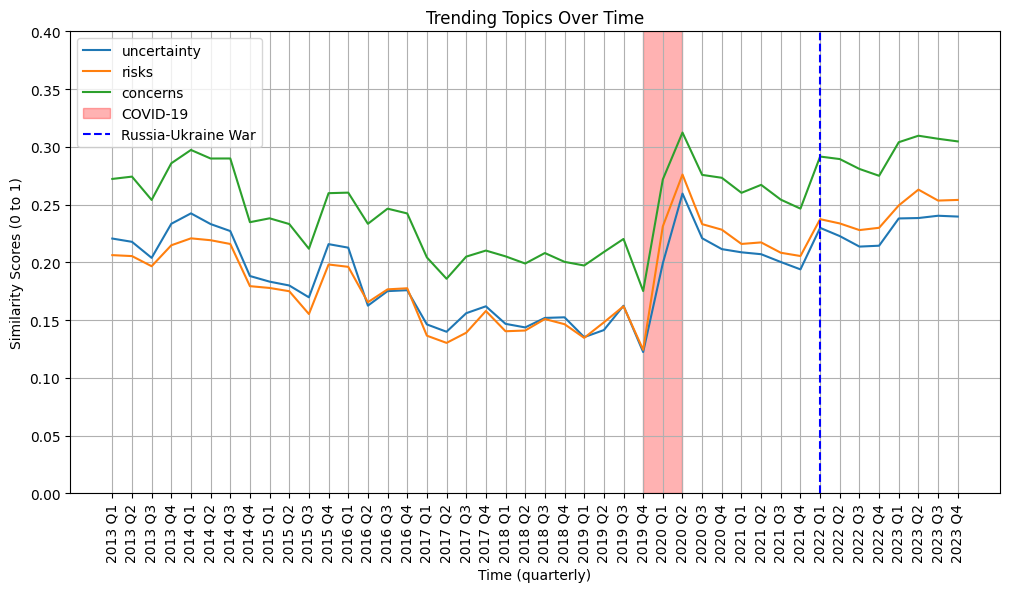

In [85]:
topics = ['uncertainty', 'risks', 'concerns']
# topics = ['supply', 'demand']
# topics = ['stability', 'inflation']
# topics = ['exchange', 'foreign', 'stability', 'policy', 'outlook', 'growth', 'credit', 'domestic', 'external', 'oil', 'commodity']
# topics = ['demand', 'domestic', 'supply', 'external', 'oil', 'commodity']
results_list, results_dict = minilm_tm_all(topics, docs)
tm_responses(topics, results_list, results_dict)
plot_tm_all(results_list, results_dict)

## Sentiment Analysis Over Time

Describes the report outlook on different topics.

In [30]:
def finbert_sa_all(topics, docs):
    ''' finds sentiment analysis for each topic for each document 
    topics: List[str]
    docs: Dict[qy: Report]'''
    
    start = time.time()
    
    # List[[quarter, year, scores]]
    results_list = [[key[1], key[4:], finbert_hf_sa(topics, doc, verbose = False)] 
                   for key, doc in docs.items()]
    # Dict{topic: scores}
    results_dict = {topics[i]: 
                    [results_list[j][2][i] for j in range(len(results_list))]
                     for i in range(len(topics))}
    
    end = time.time()
    print(f"All sentiment analyses completed in {end - start} seconds.")
    
    return results_list, results_dict
    
def plot_sa_all(results_list, results_dict):
    ''' plots sentiment analysis results using matplot 
    results_list: List[[quarter, year, score]]
    results_dict: Dict{topic: List[score]}'''
    
    plt.figure(figsize=(12, 6))
    qys = [f'{year} Q{quarter}' for quarter, year, similarities in results_list]
    for topic, scores in results_dict.items():
        plt.plot(qys, scores, marker='o', label=topic)
    
    # label axes
    plt.xticks(rotation=90)
    plt.xlabel("Time (quarterly)")
    plt.ylabel("Sentiment Scores (-1 (neg) to 1 (pos))")
    plt.title("Outlook on Topics over Time")
    plt.ylim(-1, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 1.106668472290039 seconds.
Surveying 147 paragraphs for inflation...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3699066638946533 seconds.
Surveying 17 paragraphs for unemployment...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3591451644897461 seconds.
Surveying 9 paragraphs for oil...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.2921428680419922 seconds.
Surveying 115 paragraphs for growth...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3754439353942871 seconds.
Surveying 103 paragraphs for demand...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3723869323730469 seconds.
Surveying 35 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.39811158180236816 seconds.
Surveying 181 paragraphs for inflation...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.41942286491394043 seconds.
Surveying 35 paragraphs for unemployment...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.39345836639404297 seconds.
Surveying 9 paragraphs for oil...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3237946033477783 seconds.
Surveying 138 paragraphs for growth...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.41455531120300293 seconds.
Surveying 140 paragraphs for demand...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.41205859184265137 seconds.
Surveying 46 paragraphs for supply...
5 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.315136194229126 seconds.
Surveying 141 paragraphs for inflation...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.30529356002807617 seconds.
Surveying 35 paragraphs for unemployment...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3173391819000244 seconds.
Surveying 9 paragraphs for oil...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.24308443069458008 seconds.
Surveying 105 paragraphs for growth...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.307384729385376 seconds.
Surveying 106 paragraphs for demand...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3092365264892578 seconds.
Surveying 28 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3724396228790283 seconds.
Surveying 185 paragraphs for inflation...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3824479579925537 seconds.
Surveying 41 paragraphs for unemployment...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.39729905128479004 seconds.
Surveying 10 paragraphs for oil...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3049454689025879 seconds.
Surveying 148 paragraphs for growth...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3659214973449707 seconds.
Surveying 149 paragraphs for demand...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.37453627586364746 seconds.
Surveying 38 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.4950435161590576 seconds.
Surveying 164 paragraphs for inflation...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.4607522487640381 seconds.
Surveying 32 paragraphs for unemployment...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.4415779113769531 seconds.
Surveying 10 paragraphs for oil...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.380387544631958 seconds.
Surveying 127 paragraphs for growth...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.455413818359375 seconds.
Surveying 131 paragraphs for demand...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.45817041397094727 seconds.
Surveying 33 paragraphs for supply...
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.3807666301727295 seconds.
Surveying 190 paragraphs for inflation...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.37715959548950195 seconds.
Surveying 42 paragraphs for unemployment...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.3837552070617676 seconds.
Surveying 15 paragraphs for oil...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.30528950691223145 seconds.
Surveying 145 paragraphs for growth...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.392956018447876 seconds.
Surveying 153 paragraphs for demand...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.3979527950286865 seconds.
Surveying 42 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.4082953929901123 seconds.
Surveying 188 paragraphs for inflation...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.38544416427612305 seconds.
Surveying 37 paragraphs for unemployment...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.3774430751800537 seconds.
Surveying 20 paragraphs for oil...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.4115164279937744 seconds.
Surveying 156 paragraphs for growth...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.38695406913757324 seconds.
Surveying 149 paragraphs for demand...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.39145922660827637 seconds.
Surveying 44 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.3696727752685547 seconds.
Surveying 197 paragraphs for inflation...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.3627023696899414 seconds.
Surveying 30 paragraphs for unemployment...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.38927412033081055 seconds.
Surveying 12 paragraphs for oil...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.30335474014282227 seconds.
Surveying 133 paragraphs for growth...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.38359999656677246 seconds.
Surveying 135 paragraphs for demand...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.3590850830078125 seconds.
Surveying 40 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.42632341384887695 seconds.
Surveying 239 paragraphs for inflation...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.41708922386169434 seconds.
Surveying 29 paragraphs for unemployment...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.431807279586792 seconds.
Surveying 19 paragraphs for oil...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.45354652404785156 seconds.
Surveying 148 paragraphs for growth...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.4212970733642578 seconds.
Surveying 163 paragraphs for demand...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.4206240177154541 seconds.
Surveying 49 paragraphs for supply...
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.4030478000640869 seconds.
Surveying 232 paragraphs for inflation...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.39420366287231445 seconds.
Surveying 27 paragraphs for unemployment...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.4246242046356201 seconds.
Surveying 15 paragraphs for oil...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.41257667541503906 seconds.
Surveying 157 paragraphs for growth...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.4158608913421631 seconds.
Surveying 160 paragraphs for demand...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Text similarity retrieved in 0.42463040351867676 seconds.
Surveying 40 paragraphs for supply...
19 paragraphs with possibly faulty results.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.3202996253967285 seconds.
Surveying 80 paragraphs for inflation...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.31589579582214355 seconds.
Surveying 7 paragraphs for unemployment...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.2454671859741211 seconds.
Surveying 8 paragraphs for oil...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.3211066722869873 seconds.
Surveying 54 paragraphs for growth...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.32359862327575684 seconds.
Surveying 59 paragraphs for demand...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.3187255859375 seconds.
Surveying 17 paragraphs for supply...
21 paragraphs with possibly faulty results.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.34829068183898926 seconds.
Surveying 75 paragraphs for inflation...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.33469724655151367 seconds.
Surveying 10 paragraphs for unemployment...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.33268213272094727 seconds.
Surveying 8 paragraphs for oil...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.345318078994751 seconds.
Surveying 57 paragraphs for growth...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.3277919292449951 seconds.
Surveying 57 paragraphs for demand...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.34104013442993164 seconds.
Surveying 17 paragraphs for supply...
24 paragraphs with possibly faulty results.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.35233545303344727 seconds.
Surveying 72 paragraphs for inflation...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.3576042652130127 seconds.
Surveying 8 paragraphs for unemployment...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.32342958450317383 seconds.
Surveying 9 paragraphs for oil...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.3438277244567871 seconds.
Surveying 46 paragraphs for growth...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.3338325023651123 seconds.
Surveying 56 paragraphs for demand...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Text similarity retrieved in 0.35297632217407227 seconds.
Surveying 16 paragraphs for supply...
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.3881807327270508 seconds.
Surveying 193 paragraphs for inflation...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.421018123626709 seconds.
Surveying 30 paragraphs for unemployment...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.38990211486816406 seconds.
Surveying 16 paragraphs for oil...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.4123520851135254 seconds.
Surveying 139 paragraphs for growth...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.39253830909729004 seconds.
Surveying 149 paragraphs for demand...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.40569376945495605 seconds.
Surveying 44 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.44242143630981445 seconds.
Surveying 211 paragraphs for inflation...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.44605517387390137 seconds.
Surveying 37 paragraphs for unemployment...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.4378676414489746 seconds.
Surveying 14 paragraphs for oil...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.4354362487792969 seconds.
Surveying 147 paragraphs for growth...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.4375474452972412 seconds.
Surveying 158 paragraphs for demand...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.45456624031066895 seconds.
Surveying 48 paragraphs for supply...
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.40343523025512695 seconds.
Surveying 186 paragraphs for inflation...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.37880778312683105 seconds.
Surveying 27 paragraphs for unemployment...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.37396955490112305 seconds.
Surveying 13 paragraphs for oil...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3122897148132324 seconds.
Surveying 133 paragraphs for growth...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3940925598144531 seconds.
Surveying 140 paragraphs for demand...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3715972900390625 seconds.
Surveying 37 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.39612817764282227 seconds.
Surveying 200 paragraphs for inflation...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.38788533210754395 seconds.
Surveying 31 paragraphs for unemployment...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.4085988998413086 seconds.
Surveying 11 paragraphs for oil...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.32716798782348633 seconds.
Surveying 125 paragraphs for growth...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.4098646640777588 seconds.
Surveying 141 paragraphs for demand...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.4038259983062744 seconds.
Surveying 34 paragraphs for supply...
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3100564479827881 seconds.
Surveying 153 paragraphs for inflation...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.334885835647583 seconds.
Surveying 25 paragraphs for unemployment...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3055288791656494 seconds.
Surveying 6 paragraphs for oil...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.2629845142364502 seconds.
Surveying 91 paragraphs for growth...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.329456090927124 seconds.
Surveying 105 paragraphs for demand...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.31179046630859375 seconds.
Surveying 26 paragraphs for supply...
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.30767130851745605 seconds.
Surveying 138 paragraphs for inflation...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.2883617877960205 seconds.
Surveying 18 paragraphs for unemployment...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.30118656158447266 seconds.
Surveying 6 paragraphs for oil...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.23305797576904297 seconds.
Surveying 92 paragraphs for growth...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3183150291442871 seconds.
Surveying 98 paragraphs for demand...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3194870948791504 seconds.
Surveying 21 paragraphs for supply...
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.32720327377319336 seconds.
Surveying 194 paragraphs for inflation...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.3559443950653076 seconds.
Surveying 38 paragraphs for unemployment...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.33086681365966797 seconds.
Surveying 26 paragraphs for oil...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.34323596954345703 seconds.
Surveying 129 paragraphs for growth...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.336916446685791 seconds.
Surveying 148 paragraphs for demand...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Text similarity retrieved in 0.3178694248199463 seconds.
Surveying 43 paragraphs for supply...
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.2981860637664795 seconds.
Surveying 144 paragraphs for inflation...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.2932286262512207 seconds.
Surveying 35 paragraphs for unemployment...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.30202174186706543 seconds.
Surveying 13 paragraphs for oil...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.2215738296508789 seconds.
Surveying 101 paragraphs for growth...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.2921290397644043 seconds.
Surveying 114 paragraphs for demand...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.33846402168273926 seconds.
Surveying 25 paragraphs for supply...
0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3000526428222656 seconds.
Surveying 147 paragraphs for inflation...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3048083782196045 seconds.
Surveying 30 paragraphs for unemployment...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.28778743743896484 seconds.
Surveying 13 paragraphs for oil...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.25412535667419434 seconds.
Surveying 97 paragraphs for growth...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.2986276149749756 seconds.
Surveying 109 paragraphs for demand...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.30727648735046387 seconds.
Surveying 15 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.2575650215148926 seconds.
Surveying 153 paragraphs for inflation...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3150136470794678 seconds.
Surveying 28 paragraphs for unemployment...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3213930130004883 seconds.
Surveying 13 paragraphs for oil...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.24711894989013672 seconds.
Surveying 105 paragraphs for growth...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.32462167739868164 seconds.
Surveying 114 paragraphs for demand...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3078889846801758 seconds.
Surveying 24 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.34232497215270996 seconds.
Surveying 154 paragraphs for inflation...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3278498649597168 seconds.
Surveying 29 paragraphs for unemployment...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.32778215408325195 seconds.
Surveying 12 paragraphs for oil...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.2594590187072754 seconds.
Surveying 108 paragraphs for growth...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3421168327331543 seconds.
Surveying 114 paragraphs for demand...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.33236026763916016 seconds.
Surveying 22 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3158409595489502 seconds.
Surveying 148 paragraphs for inflation...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.31424546241760254 seconds.
Surveying 29 paragraphs for unemployment...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.31365489959716797 seconds.
Surveying 10 paragraphs for oil...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.24353814125061035 seconds.
Surveying 95 paragraphs for growth...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.2902696132659912 seconds.
Surveying 93 paragraphs for demand...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3177766799926758 seconds.
Surveying 24 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.31034255027770996 seconds.
Surveying 147 paragraphs for inflation...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.30503177642822266 seconds.
Surveying 23 paragraphs for unemployment...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.31873226165771484 seconds.
Surveying 10 paragraphs for oil...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.24048113822937012 seconds.
Surveying 85 paragraphs for growth...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.30670642852783203 seconds.
Surveying 98 paragraphs for demand...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3258707523345947 seconds.
Surveying 29 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.30435895919799805 seconds.
Surveying 154 paragraphs for inflation...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.31710076332092285 seconds.
Surveying 32 paragraphs for unemployment...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3325939178466797 seconds.
Surveying 12 paragraphs for oil...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.24286890029907227 seconds.
Surveying 92 paragraphs for growth...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3168470859527588 seconds.
Surveying 107 paragraphs for demand...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3233489990234375 seconds.
Surveying 27 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3024303913116455 seconds.
Surveying 151 paragraphs for inflation...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.31254076957702637 seconds.
Surveying 35 paragraphs for unemployment...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.32680773735046387 seconds.
Surveying 11 paragraphs for oil...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.2619969844818115 seconds.
Surveying 95 paragraphs for growth...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.31012678146362305 seconds.
Surveying 94 paragraphs for demand...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.30483055114746094 seconds.
Surveying 25 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3145909309387207 seconds.
Surveying 147 paragraphs for inflation...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.31725192070007324 seconds.
Surveying 19 paragraphs for unemployment...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3372790813446045 seconds.
Surveying 15 paragraphs for oil...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.261721134185791 seconds.
Surveying 87 paragraphs for growth...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.3305840492248535 seconds.
Surveying 97 paragraphs for demand...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Text similarity retrieved in 0.32758617401123047 seconds.
Surveying 30 paragraphs for supply...
3 paragraphs with possibly faulty results.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Text similarity retrieved in 0.288022518157959 seconds.
Surveying 103 paragraphs for inflation...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Text similarity retrieved in 0.27433300018310547 seconds.
Surveying 29 paragraphs for unemployment...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Text similarity retrieved in 0.2865767478942871 seconds.
Surveying 8 paragraphs for oil...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Text similarity retrieved in 0.214188814163208 seconds.
Surveying 54 paragraphs for growth...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Text similarity retrieved in 0.2899153232574463 seconds.
Surveying 71 paragraphs for demand...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Text similarity retrieved in 0.27777862548828125 seconds.
Surveying 15 paragraphs for supply...
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.4173011779785156 seconds.
Surveying 280 paragraphs for inflation...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.43813014030456543 seconds.
Surveying 66 paragraphs for unemployment...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.4300110340118408 seconds.
Surveying 18 paragraphs for oil...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.4294466972351074 seconds.
Surveying 158 paragraphs for growth...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.43680477142333984 seconds.
Surveying 191 paragraphs for demand...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.44518589973449707 seconds.
Surveying 44 paragraphs for supply...
3 paragraphs with possibly faulty results.


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Text similarity retrieved in 0.4056668281555176 seconds.
Surveying 252 paragraphs for inflation...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Text similarity retrieved in 0.39018893241882324 seconds.
Surveying 36 paragraphs for unemployment...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Text similarity retrieved in 0.3841249942779541 seconds.
Surveying 21 paragraphs for oil...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Text similarity retrieved in 0.4116640090942383 seconds.
Surveying 149 paragraphs for growth...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Text similarity retrieved in 0.3791940212249756 seconds.
Surveying 178 paragraphs for demand...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Text similarity retrieved in 0.3963968753814697 seconds.
Surveying 53 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.45365285873413086 seconds.
Surveying 298 paragraphs for inflation...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.4765763282775879 seconds.
Surveying 54 paragraphs for unemployment...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.4510352611541748 seconds.
Surveying 37 paragraphs for oil...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.45572590827941895 seconds.
Surveying 180 paragraphs for growth...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.45233583450317383 seconds.
Surveying 204 paragraphs for demand...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.46805691719055176 seconds.
Surveying 68 paragraphs for supply...
4 paragraphs with possibly faulty results.


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.6771471500396729 seconds.
Surveying 295 paragraphs for inflation...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.6765120029449463 seconds.
Surveying 49 paragraphs for unemployment...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.6770937442779541 seconds.
Surveying 26 paragraphs for oil...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.6775524616241455 seconds.
Surveying 184 paragraphs for growth...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.6727139949798584 seconds.
Surveying 195 paragraphs for demand...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.7005093097686768 seconds.
Surveying 64 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.391312837600708 seconds.
Surveying 275 paragraphs for inflation...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.3936471939086914 seconds.
Surveying 39 paragraphs for unemployment...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.39292359352111816 seconds.
Surveying 28 paragraphs for oil...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.3981285095214844 seconds.
Surveying 184 paragraphs for growth...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.4138345718383789 seconds.
Surveying 194 paragraphs for demand...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.425213098526001 seconds.
Surveying 57 paragraphs for supply...
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.41635966300964355 seconds.
Surveying 304 paragraphs for inflation...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.43106508255004883 seconds.
Surveying 33 paragraphs for unemployment...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.4418973922729492 seconds.
Surveying 34 paragraphs for oil...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.4265251159667969 seconds.
Surveying 215 paragraphs for growth...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.4255537986755371 seconds.
Surveying 223 paragraphs for demand...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.42804908752441406 seconds.
Surveying 72 paragraphs for supply...
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Text similarity retrieved in 0.4962918758392334 seconds.
Surveying 340 paragraphs for inflation...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Text similarity retrieved in 0.5099115371704102 seconds.
Surveying 52 paragraphs for unemployment...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Text similarity retrieved in 0.49768853187561035 seconds.
Surveying 90 paragraphs for oil...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Text similarity retrieved in 0.4974508285522461 seconds.
Surveying 196 paragraphs for growth...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Text similarity retrieved in 0.5207171440124512 seconds.
Surveying 256 paragraphs for demand...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Text similarity retrieved in 0.5006718635559082 seconds.
Surveying 128 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.6551742553710938 seconds.
Surveying 313 paragraphs for inflation...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.6555860042572021 seconds.
Surveying 57 paragraphs for unemployment...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.675060510635376 seconds.
Surveying 34 paragraphs for oil...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.6750311851501465 seconds.
Surveying 188 paragraphs for growth...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.6584198474884033 seconds.
Surveying 218 paragraphs for demand...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Text similarity retrieved in 0.678992509841919 seconds.
Surveying 75 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.618577241897583 seconds.
Surveying 267 paragraphs for inflation...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.6104445457458496 seconds.
Surveying 49 paragraphs for unemployment...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.6184487342834473 seconds.
Surveying 27 paragraphs for oil...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.597792387008667 seconds.
Surveying 161 paragraphs for growth...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.6025946140289307 seconds.
Surveying 194 paragraphs for demand...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.6182191371917725 seconds.
Surveying 60 paragraphs for supply...
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.39867424964904785 seconds.
Surveying 276 paragraphs for inflation...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.39782214164733887 seconds.
Surveying 51 paragraphs for unemployment...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.40276193618774414 seconds.
Surveying 39 paragraphs for oil...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.41313791275024414 seconds.
Surveying 185 paragraphs for growth...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.3942403793334961 seconds.
Surveying 199 paragraphs for demand...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Text similarity retrieved in 0.381270170211792 seconds.
Surveying 73 paragraphs for supply...
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Text similarity retrieved in 0.46590137481689453 seconds.
Surveying 331 paragraphs for inflation...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Text similarity retrieved in 0.4863245487213135 seconds.
Surveying 60 paragraphs for unemployment...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Text similarity retrieved in 0.49507808685302734 seconds.
Surveying 47 paragraphs for oil...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Text similarity retrieved in 0.48693180084228516 seconds.
Surveying 192 paragraphs for growth...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Text similarity retrieved in 0.4724864959716797 seconds.
Surveying 267 paragraphs for demand...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Text similarity retrieved in 0.4950706958770752 seconds.
Surveying 64 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.34858083724975586 seconds.
Surveying 171 paragraphs for inflation...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.33991169929504395 seconds.
Surveying 42 paragraphs for unemployment...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3620259761810303 seconds.
Surveying 32 paragraphs for oil...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.34995555877685547 seconds.
Surveying 116 paragraphs for growth...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3494858741760254 seconds.
Surveying 144 paragraphs for demand...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Text similarity retrieved in 0.3656580448150635 seconds.
Surveying 41 paragraphs for supply...
2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.40731239318847656 seconds.
Surveying 274 paragraphs for inflation...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.4424247741699219 seconds.
Surveying 57 paragraphs for unemployment...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.419386625289917 seconds.
Surveying 38 paragraphs for oil...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.4186115264892578 seconds.
Surveying 170 paragraphs for growth...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.4044172763824463 seconds.
Surveying 230 paragraphs for demand...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.416715145111084 seconds.
Surveying 55 paragraphs for supply...
1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.3902010917663574 seconds.
Surveying 275 paragraphs for inflation...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.3984825611114502 seconds.
Surveying 63 paragraphs for unemployment...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.40547823905944824 seconds.
Surveying 36 paragraphs for oil...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.42314624786376953 seconds.
Surveying 164 paragraphs for growth...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.39793944358825684 seconds.
Surveying 232 paragraphs for demand...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Text similarity retrieved in 0.394275426864624 seconds.
Surveying 56 paragraphs for supply...
All sentiment analyses completed in 3078.2823536396027 seconds.


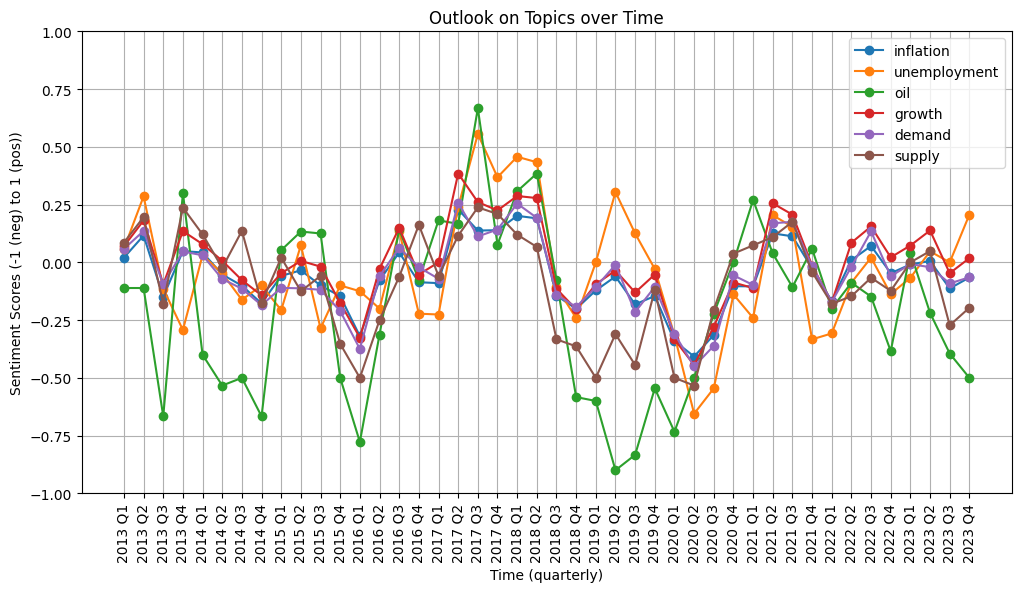

In [31]:
topics = ['inflation', 'unemployment', 'oil', 'growth', 'demand', 'supply'] # choose topics here
results_list, results_dict = finbert_sa_all(topics, docs)
plot_sa_all(results_list, results_dict)

## Information Retrieval

Answers questions across documents.

In [81]:
import heapq

class Passage():
    # fields: id: ID, text: str, sim: int
    def __init__(self, year: int, quarter: int, text: str, sim: int):
        self.id = ID(year, quarter)
        self.text = text
        self.sim = sim
        
    def __lt__(self, other):
        return self.sim < other.sim

# find most relevant passages
def minilm_hf_search(query: str, docs, k: int):
    ''' finds top k passage results from docs to answer query
    docs: Dict[str: Report]'''
    
    if query == '':
        raise ValueError("No query provided.")
    
    start = time.time()
    all_sims = []
    
    for key, doc in docs.items():
        quarter = int(key[1])
        year = int(key[4:])
        
        texts = []
        faulty = 0
        
        # get paragraphs in list
        for section in doc.body:
            for paragraph in section.body:
                spaces = paragraph.body.count(' ')
                if spaces > 10:
                    texts.append(paragraph.body)
                if paragraph.body.count(' ') > 250:
                    faulty += 1
        n = len(texts)
    
        # number of paragraphs with faulty results (greater than model max sequence length)
        print(f"{faulty} paragraphs with possibly faulty results.")
        
        # obtain all similarities
        similarities = minilm_hf(query, texts, verbose=False)
        clean_sims = [float(similarities[[0], [i]]) for i in range(n)]
        for i in range(len(clean_sims)):
            all_sims.append(Passage(year, quarter, texts[i], clean_sims[i]))
        
    # min heap for best scores
    heap = []
    
    for passage in all_sims:
        if len(heap) < k:
            heapq.heappush(heap, passage)
        else:
            if passage.sim > heap[0].sim:
                heapq.heapreplace(heap, passage)
    results = sorted(heap, key=lambda psg: psg.sim)
    
    end = time.time()
    print(f"Information retrieval completed in {end - start} seconds.")
    
    return results

In [78]:
# rerank relevant passages
def xencode(query: str, passages):
    ''' reranks relevant k passages and outputs them from most relevant to least relevant 
    passages: List[Passage]'''
    start = time.time()
    scores = list(xencode_hf(query, [passage.text for passage in passages]))
    
    scores_to_passage = { score : i for i, score in enumerate(scores) }
    scores.sort()
    scores.reverse()
    
    results = [passages[scores_to_passage[score]] for score in scores]
    
    end = time.time()
    print(f"Reranking completed in {end - start} seconds.")
    return results

# consolidate answers
def combine_info(query, passages):
    ''' combines answers from passages into a general answer '''
    
    system_info_com = '''You are an AI assistant designed to combine answers.
    You will be provided the top answers to a given search query from most relevant
    to least relevant. Please combine these answers into a very brief general answer
    keeping in mind each answer's relevance.
    '''
    start = time.time()
    
    prompt = f"Search query: {query}\n"
    for i, passage in enumerate(passages):
        prompt += f"Answer {i}: {passage.text}\n"
    
    response = llama3_hf(system_info_com, prompt=prompt, temperature=0.1, max_length=500)
    result = get_answer(response)
    
    end = time.time()
    print(f"Answers conslidated in {end - start} seconds.")
    
    return result

In [79]:
# formats response from information retrieval
def get_ir(query: str, docs, k:int):
    ''' retrieves top k answer for query across docs 
    docs: Dict{str: Report}'''
    top_psgs = minilm_hf_search(query, docs, k)
    reranked_psgs = xencode(query, top_psgs)
    general = combine_info(query, reranked_psgs)
    
    print(f"Answer: {general}\n")
    for i, passage in enumerate(reranked_psgs):
        print(f"Result {i + 1}: ({passage.id.year} Q{passage.id.quarter}) [{passage.sim}] {passage.text}\n")

In [83]:
query = 'What are the most prominent concerns of coronavirus?'
k = 10

get_ir(query, docs, k)

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

5 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

19 paragraphs with possibly faulty results.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

21 paragraphs with possibly faulty results.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

24 paragraphs with possibly faulty results.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

0 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

3 paragraphs with possibly faulty results.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

3 paragraphs with possibly faulty results.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

4 paragraphs with possibly faulty results.


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

2 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

1 paragraphs with possibly faulty results.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Information retrieval completed in 12.569108486175537 seconds.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cross encoding completed in 0.03620433807373047 seconds.
Reranking completed in 0.03683185577392578 seconds.
Query prompted in 10.659535884857178 seconds.
Answers conslidated in 10.675926923751831 seconds.
Answer:  Here is a brief general answer combining the top answers:

The most prominent concerns of the coronavirus pandemic include the ongoing high level of spread in many countries, uncertainties about the future, especially in developing countries, and the impact on the global and Armenian economies. The pandemic's effects on macroeconomic environment and financial markets are a major focus, with concerns about external demand risks, the prevalence of new coronavirus mutations, and the potential for restrictions on economic activity. The spread of the disease, anti-epidemic measures, and their impact on the labor force are also key concerns. However, there is optimism about the development and use of vaccines, which are expected to mitigate the negative effects in the medium term.